# Project 2 - INF264
*By Kim Austgulen and Fillip Lampe*

Short overview on this file, this will mainly focus on the results and the basis of what we will write in our report. As we want to keep this file more clean, we have most of the code move into our import files.

In [1]:
import numpy as np

In [2]:
seed = 42
np.random.seed(seed)

In [3]:
dataset = np.load('../data/dataset.npz')
X, y = dataset['X'], dataset['y']

## Task 1: 

In [17]:
# this will take around 7-8 min depending on the machine
# our SVM model class
from svm import SVM

# it will split the data and preprocess it
n = 1 # 5# number of intervals for the rand search
folds = 3 # number of folds for cross validation

# this will by deafult not use pca
svm = SVM(X, y, n, folds,seed=seed)
svm.fit()
svm_eval_info = svm.evaluate()


Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
# Our CNN models (PyTorch)
from pytorch_cnn import CNN_PT

#params must not be changed if you are gonna load the model
n = 5 # number of intervals for the rand search
folds = 3 # number of folds for cross validation
epochs = 10 # number of epochs for training
batch_size = 32 # batch size for training
path = '../other/' # path to save the models

# fit is removed as it is not reproducable
lenet_cnn_pt = CNN_PT(X, y, folds, seed, epochs, batch_size, path, model='lenet')
#lenet_cnn_pt.fit() # remove if you wanat to train the model
lenet_eval_info = lenet_cnn_pt.evaluate(load=True)

# fair warning this takes a while
# fit is removed as it is not reproducable
alexnet_cnn_pt = CNN_PT(X, y, folds, seed, epochs, batch_size, path, model='alexnet')
#alexnet_cnn_pt.fit() # remove if you wanat to train the model
alexnet_eval_info = alexnet_cnn_pt.evaluate(load=True)


Evaluating model on validation data...
Average loss: 0.0037, Accuracy: 0.9593
Evaluating model on validation data...
Average loss: 0.0033, Accuracy: 0.9559


In [ ]:
from random_forest import RandomForest

folds = 3 # number of folds for cross validation
n = 1 # 5 # number of intervals for the
bagging_n = 2 

randomforest = RandomForest(X, y, n, folds, seed)
randomforest.fit()
randomforest_eval_info = randomforest.evaluate()

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=103; total time=  12.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=103; total time=  12.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=103; total time=  11.7s
---------- training is finished. ----------

Random Search took 56.10 seconds
Best Parameters: {'n_estimators': 103, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
Accuracy: 0.8773


In [20]:
from sklearn.model_selection import train_test_split
from keras_cnn import CNN_KERAS
from preprocessing import generate_balanced_data
import keras
import tensorflow as tf

#NOTE: temp solution until I know how to handle datasplit ;-) (Her skal jeg lage egen process klasse i think)
###
#split data
X_train, X_val_test, y_train, y_val_test = train_test_split(X,y,train_size=.7,random_state=seed)
X_val,X_test,y_val,y_test = train_test_split(X_val_test,y_val_test, train_size=.5, random_state=seed)

#print(X_train.shape,y_train.shape)
X_train_aug, y_train_aug = generate_balanced_data(X_train, y_train, seed=seed)

#reshape
X_train_aug = X_train_aug.reshape(X_train_aug.shape[0], 20, 20, 1)
X_val = X_val.reshape(X_val.shape[0], 20, 20, 1)
X_test = X_test.reshape(X_test.shape[0], 20, 20, 1)

#scale (simple)
X_train_aug = X_train_aug/255
X_val = X_val/255
X_test = X_test/255


y_train_aug = keras.utils.to_categorical(y_train_aug, num_classes=17)
y_val = keras.utils.to_categorical(y_val, num_classes=17)
y_test = keras.utils.to_categorical(y_test, num_classes=17)

###



epochs = 6 # number of epochs for training
path = '../other/' # path to save the models

# This is where training happens. Fit commented out to avoid re-running

with tf.device('/CPU:0'):
    lenet_cnn_keras = CNN_KERAS(
        seed=seed,
        epochs=epochs,
        path=path,
        retrain=False,
        model='lenet'
    )
# Commented out to avoid re-training. 
#    lenet_cnn_keras.fit(X_train_aug,y_train_aug)

#NOTE: to load the new model, path must be changed (avoid overwriting original)
model = keras.models.load_model(lenet_cnn_keras.best_model_tuned_path)
loss, accu = model.evaluate(X_val,y_val)
print(f"Model accuracy on validation data : {accu:.3}, with loss:{loss:.3}")

47/47 [==============================] - 1s 21ms/step - loss: 0.1031 - accuracy: 0.9736
Model accuracy on validation data : 0.974, with loss:0.103


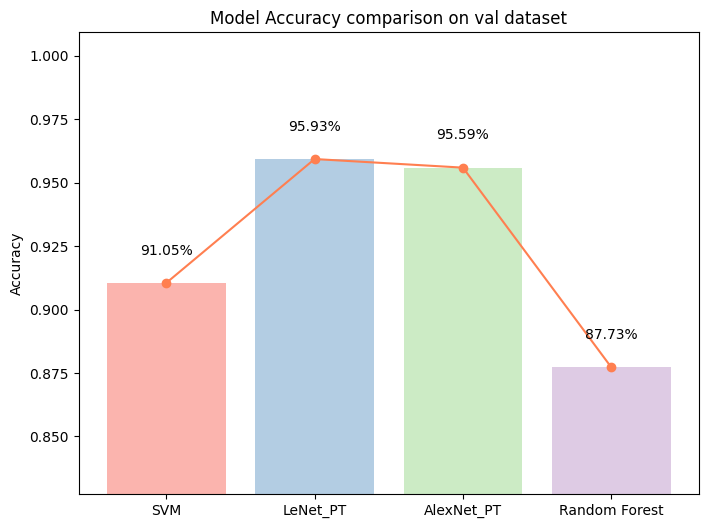

In [ ]:
from visiualising import compare_model_accuracy

labels = ['SVM', 'LeNet_PT', 'AlexNet_PT', 'Random Forest']
compare_model_accuracy(
    "Model Accuracy comparison on val dataset",
    labels,
    svm_eval_info[1], 
    lenet_eval_info[1], 
    alexnet_eval_info[1],
    randomforest_eval_info[1]
    )

In [ ]:
# Extract the accuracy values
accuracies = {
    'SVM': svm_eval_info[1],
    'LeNet_PT': lenet_eval_info[1],
    'AlexNet_PT': alexnet_eval_info[1],
    'Random Forest': randomforest_eval_info[1]
}

# Find the model with the best accuracy
best_model = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_model]

print(f"The model with the best accuracy is {best_model} with an accuracy of {best_accuracy:.2f}")

The model with the best accuracy is LeNet_PT with an accuracy of 0.96


Small differences in hardware, like using different CPUs, can result in slightly different floating-point arithmetic, affecting model performance across runs. Due to these reproducability issues it is better to choose svm 

### Final Test:

Accuracy: 0.9207


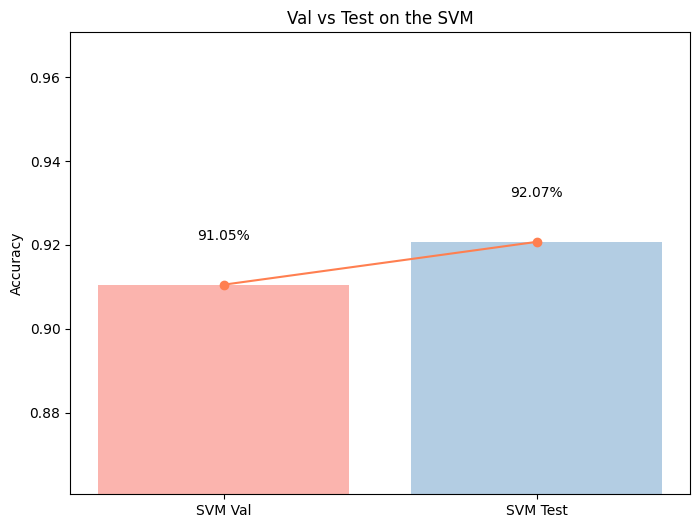

In [ ]:
#Val vs Test on our best final model (SVM)
svm_test_info = svm.test()

labels = ["SVM Val", "SVM Test"]
compare_model_accuracy("Val vs Test on the SVM", labels, svm_eval_info[1], svm_test_info[1])

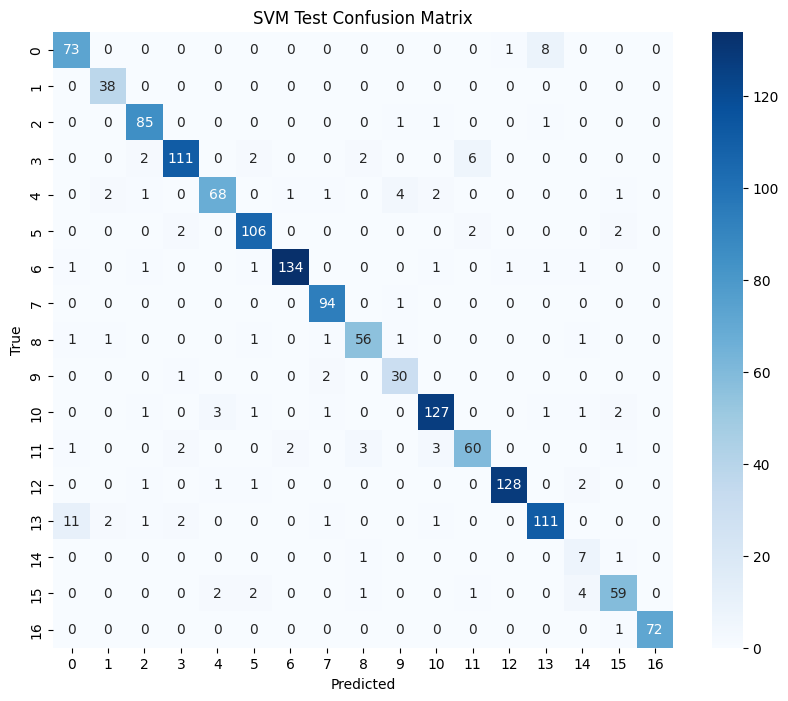

In [ ]:
from visiualising import visualize_confusion_matrix
# comfusion matrix
visualize_confusion_matrix(svm_test_info[3], svm_test_info[0], "SVM Test Confusion Matrix")

## Task 2:

In [ ]:
# Our SVM model with PCA
n = 1 # 3 # number of intervals for the rand search
folds = 3 # number of folds for cross validation
pca_n = 1 # 3 # number of pca components it will test

svm_pca = SVM(X, y, n, folds, pca_n, seed=seed, pca=True)
svm_pca.fit()
svm_pca_eval_info = svm_pca.evaluate()
svm_pca_test_info = svm_pca.test()

Starting PCA training...

--Training with 0.90 components 1/1--
Data went from (11747, 576) to (11747, 158)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END C=73.8459779302997, coef0=0.7790496653525528, degree=2, gamma=0.01135265110257893, kernel=poly, shrinking=True; total time=   5.2s
[CV] END C=73.8459779302997, coef0=0.7790496653525528, degree=2, gamma=0.01135265110257893, kernel=poly, shrinking=True; total time=   5.1s
[CV] END C=73.8459779302997, coef0=0.7790496653525528, degree=2, gamma=0.01135265110257893, kernel=poly, shrinking=True; total time=   4.8s
Random Search for 0.90 took 24.31 s
---------- training is finished. ----------

PCA training took 24.51 seconds
Best Parameters: {'C': 73.8459779302997, 'coef0': 0.7790496653525528, 'degree': 2, 'gamma': 0.01135265110257893, 'kernel': 'poly', 'shrinking': True} and best n_components: 0.9
Accuracy: 0.9112
Accuracy: 0.9262


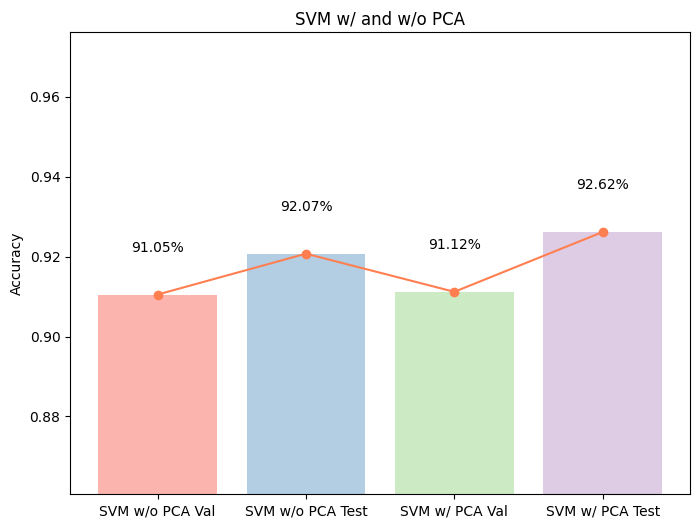

In [ ]:
labels = ["SVM w/o PCA Val", "SVM w/o PCA Test", "SVM w/ PCA Val", "SVM w/ PCA Test"]
compare_model_accuracy(
    "SVM w/ and w/o PCA", 
    labels,
    svm_eval_info[1],
    svm_test_info[1], 
    svm_pca_eval_info[1], 
    svm_pca_test_info[1])

## Task 3:

In [ ]:
dataset = np.load('../data/corrupt_dataset.npz')
X2 = dataset['X']

### Guassian Clustering of the data

In [ ]:
from ood_detection import OODDetection

ood_detector = OODDetection(
    best_svc=svm_pca.best_model, 
    best_pca=svm_pca.best_pca, 
    X_train_pca=svm_pca.X_train_pca,
    y_train=svm_pca.y_train,
    scaler=svm_pca.scaler,
    seed=seed,
    n_components=17)

X2_transformed = ood_detector.fit(X2)

predictions_probs = ood_detector.predict_guassian(X2_transformed)

g_odd_indices, g_total_odd_indices = ood_detector.detect_ood_gaussian(X2_transformed)

ood_indices_mahalanobis, num_ood_mahalanobis = ood_detector.detect_ood_mahalanobis(X2_transformed)


GaussianMixture model with 17 components fitted on training data.
Number of OOD samples: 52
Number of OOD samples (Mahalanobis): 66


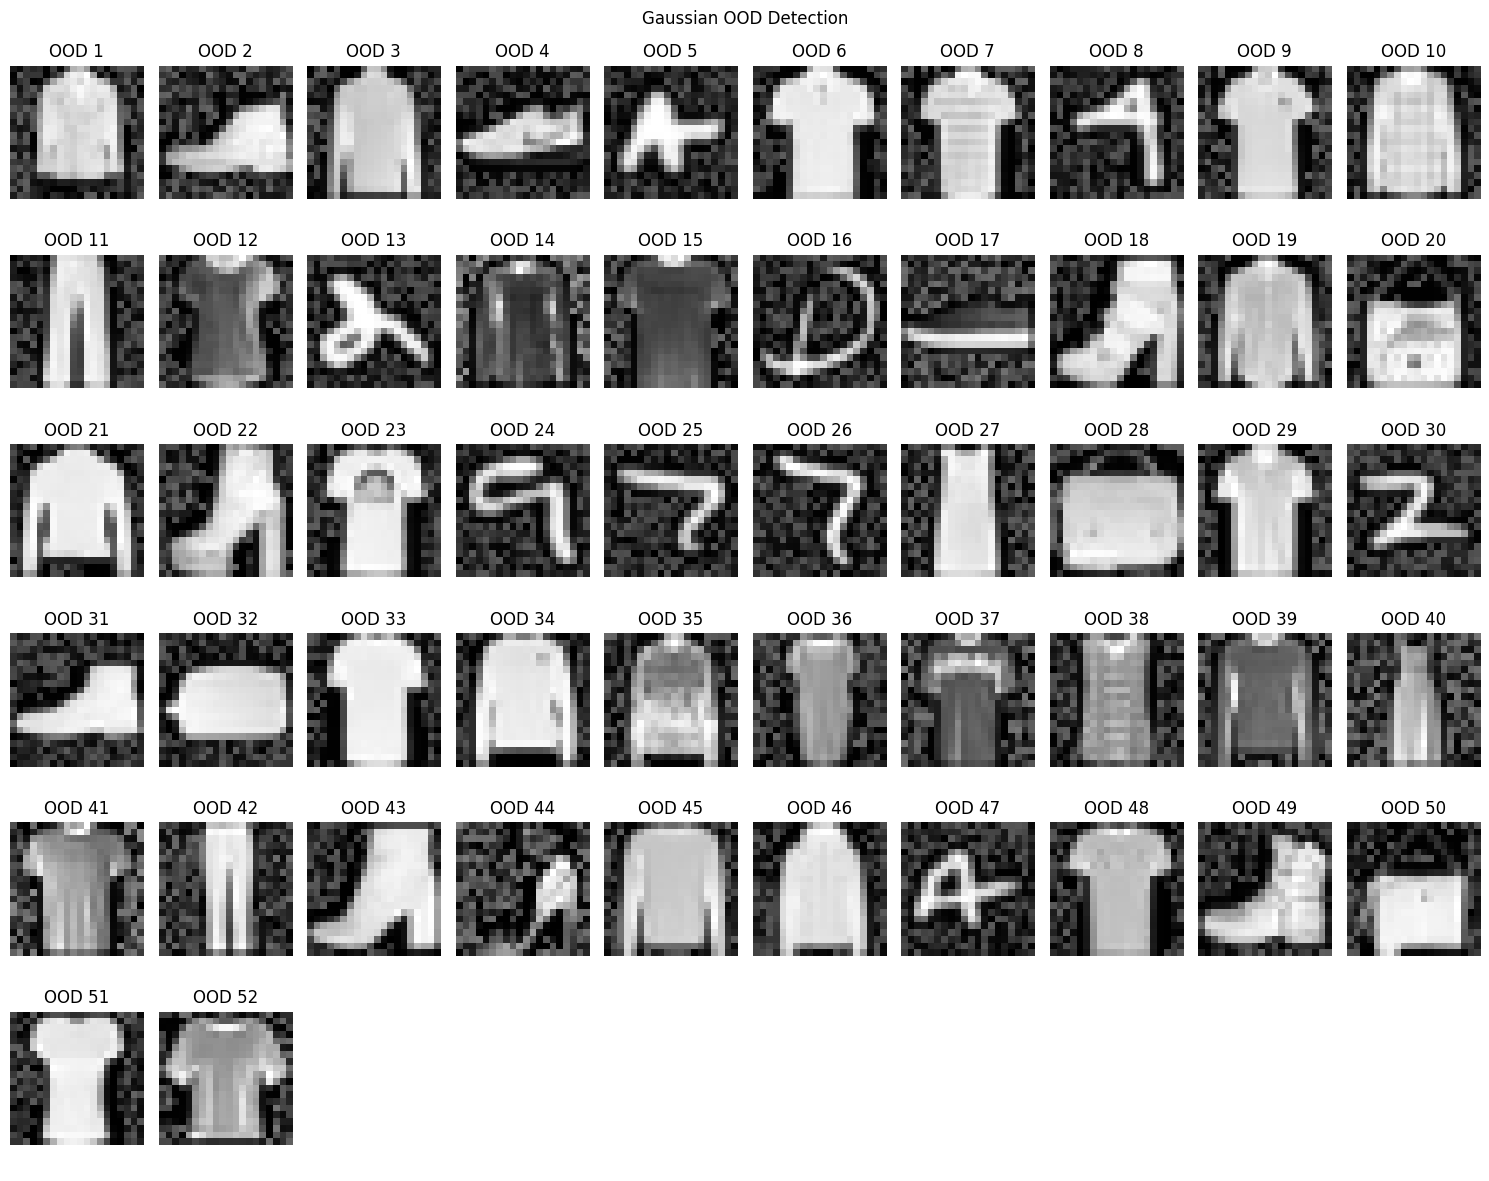

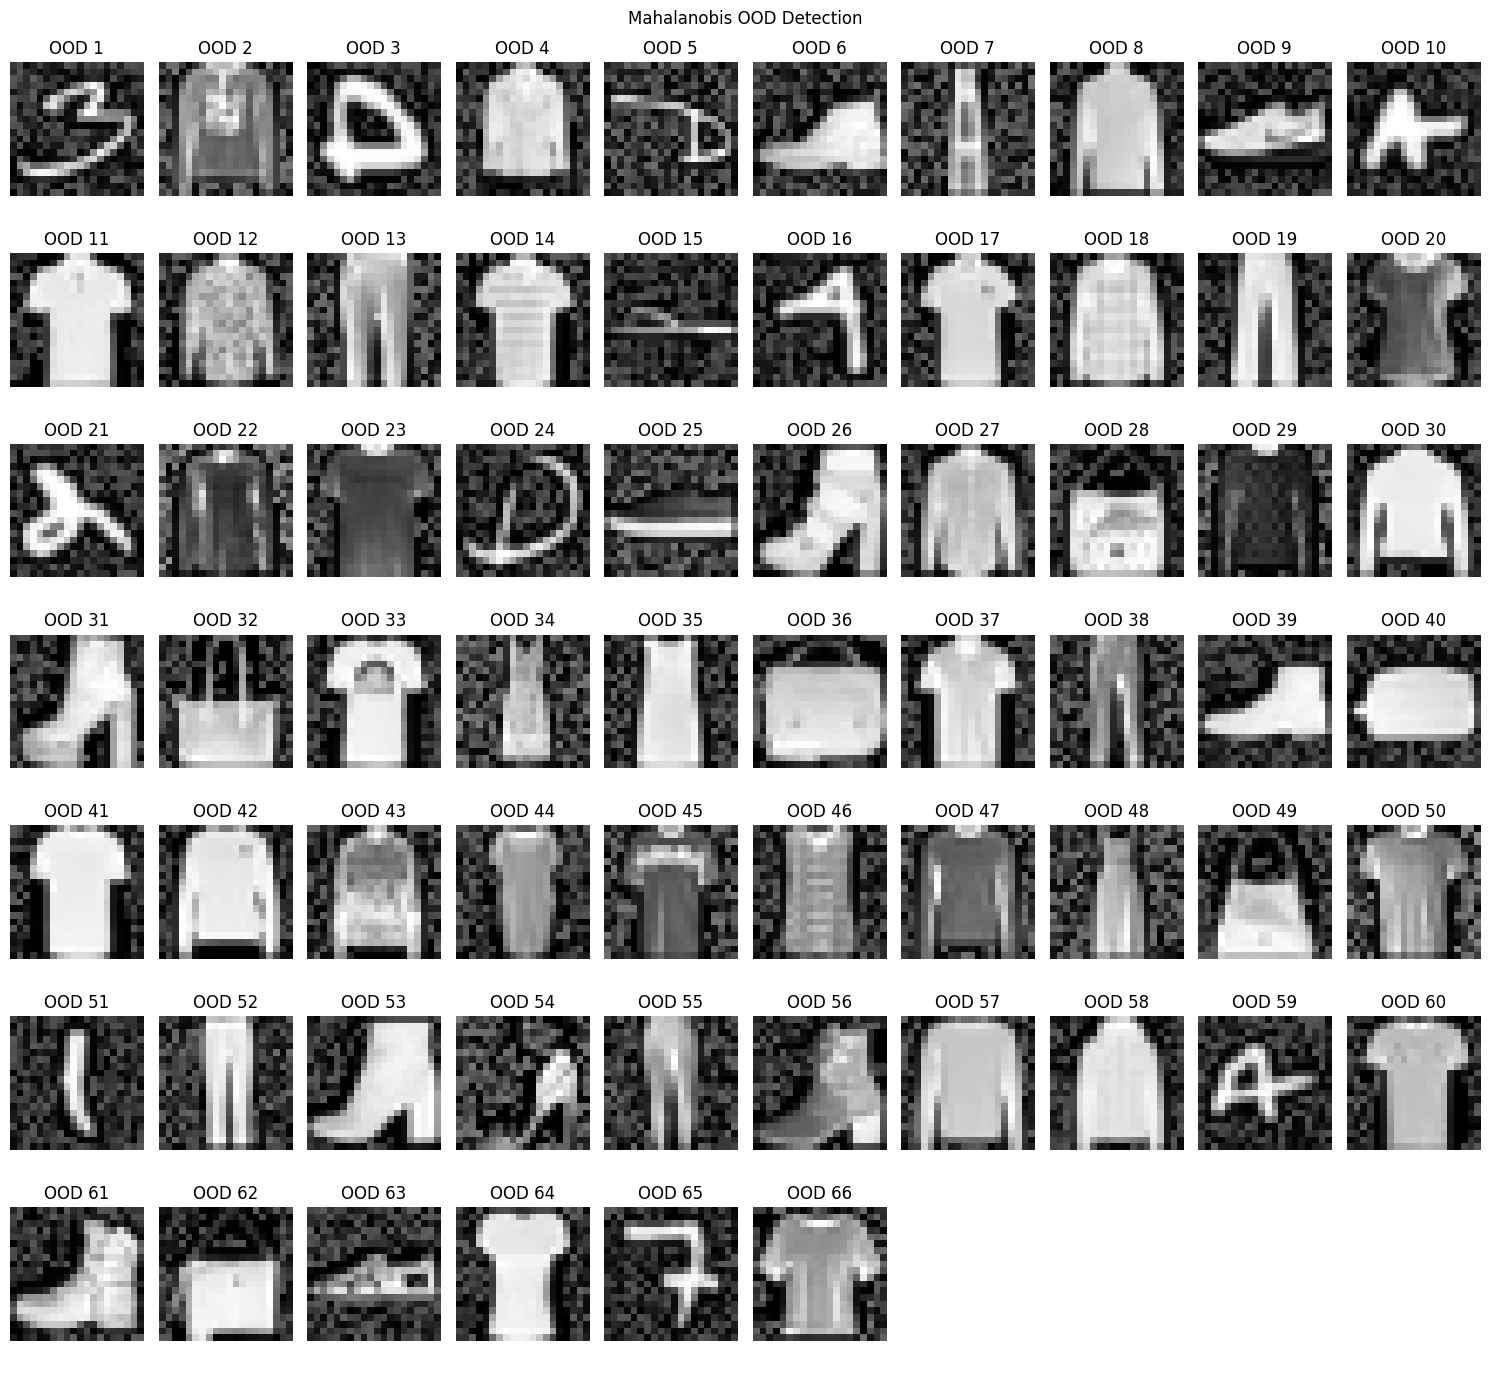

In [ ]:
from visiualising import visualize_preds

visualize_preds(X2[g_odd_indices], "Gaussian OOD Detection")
visualize_preds(X2[ood_indices_mahalanobis], "Mahalanobis OOD Detection")